In [20]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torchvision import datasets, transforms

from algebra.cliffordalgebra import CliffordAlgebra
from models.modules.gp import SteerableGeometricProductLayer
from models.modules.linear import MVLinear
from models.modules.mvlayernorm import MVLayerNorm
from models.modules.mvsilu import MVSiLU

mnist = datasets.MNIST('~/datasets/', transform=transforms.ToTensor(), download=True)
image = mnist[0][0]

In [21]:
ca = CliffordAlgebra((1., 1.))

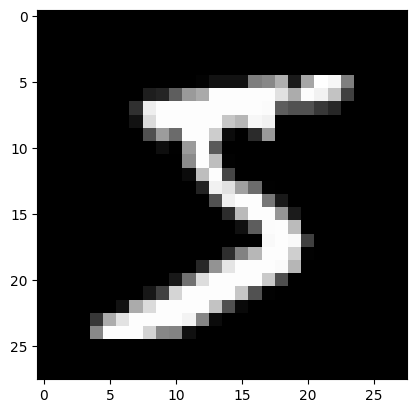

In [22]:
plt.imshow(image[0], cmap='gray')

In [23]:
image_tensor = image

In [24]:
F.grid_sample(image_tensor.unsqueeze(0), torch.tensor([[[[1., 1.]]]], dtype=torch.float32), align_corners=True, mode='nearest')

tensor([[[[0.]]]])

In [25]:
class Bilinear(nn.Module):
    def __init__(self, dim = 1024):
        super().__init__()
        self.linear_1 = nn.Linear(dim, dim)
        self.linear_2 = nn.Linear(dim, dim)
        self.a = nn.Parameter(torch.zeros(dim))
        # self.linear_3 = nn.Linear(dim, dim)


    def forward(self, x):
        b = self.linear_2(x) / (torch.sigmoid(self.a[None])*(x.abs() - 1) + 1)
        return self.linear_1(x) * b + x


In [26]:
class CEMLP(nn.Module):
    def __init__(
        self,
        algebra,
        in_features,
        hidden_features,
        out_features,
        n_layers=2,
        normalization_init=0,
    ):
        super().__init__()
        self.algebra = algebra
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.out_features = out_features
        self.n_layers = n_layers


        layers = []

        # Add geometric product layers.
        for i in range(n_layers - 1):
            layers.append(
                nn.Sequential(
                    MVLinear(self.algebra, in_features, hidden_features),
                    MVSiLU(self.algebra, hidden_features),
                    SteerableGeometricProductLayer(
                        self.algebra,
                        hidden_features,
                        normalization_init=normalization_init,
                    ),
                    MVLayerNorm(self.algebra, hidden_features),
                )
            )
            in_features = hidden_features

        # Add final layer.
        layers.append(
            nn.Sequential(
                MVLinear(self.algebra, in_features, out_features),
                MVSiLU(self.algebra, out_features),
                SteerableGeometricProductLayer(
                    self.algebra,
                    out_features,
                    normalization_init=normalization_init,
                ),
                MVLayerNorm(self.algebra, out_features),
            )
        )
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x



In [44]:
class MLP(nn.Module):
    def __init__(self, algebra, dim, hidden_dim = 1024):
        super(MLP, self).__init__()
        # self.fc_in = nn.Linear(dim, hidden_dim)
        # self.layers = nn.Sequential(
        #     *[
        #         # nn.Linear(hidden_dim, hidden_dim),
        #         Bilinear(hidden_dim)
        #     ] * 8
        # )
        # self.fc_out = nn.Sequential(nn.Linear(hidden_dim, 1))

        self.fc_in = MVLinear(algebra, dim, hidden_dim)

        self.layers = nn.Sequential(
            *[
                CEMLP(algebra, hidden_dim, hidden_dim, hidden_dim)
                for _ in range(8)
            ]
        )

        self.fc_out = MVLinear(algebra, hidden_dim, 1)


    def forward(self, x, z):
        print(x.shape, z.shape)
        x_cl = ca.embed_grade(x, 1)
        z_cl = ca.embed_grade(z, 1)
        h_cl = torch.stack([x_cl, z_cl], dim=1)
        h_cl = self.fc_in(h_cl)
        # x = self.fc_in(x)
        # # x = F.gelu(x)
        for layer in self.layers:
            h_cl = layer(h_cl)
            # x = x + F.gelu(x)
        h_cl = self.fc_out(h_cl)

        s = h_cl[:, :, 0]

        return s
    
mlp = MLP(ca, 2).cuda()
image_tensor = image_tensor.cuda()

adam = optim.Adam(mlp.parameters(), lr=1e-4)


In [45]:
batch_size = 1
num_samples_per_batch = 1024

def reflective_sin_emb(x, dim):
    result = []
    for i in range(1, dim + 1, 2):
        result.append(torch.sin(i / 2 * torch.pi * x))
    return (torch.stack(result, dim=-1) + 1) / 2

i = 0 
while True:

    # random coordinates in [-1, 1]
    random_coordinates = torch.rand(batch_size, num_samples_per_batch, 2, device='cuda') * 2 - 1
    # F.grid_sample(image_tensor.unsqueeze(0).unsqueeze(0), torch.tensor([[[[1., 1.]]]], dtype=torch.float32), align_corners=True, mode='nearest')
    targets = F.grid_sample(image_tensor.unsqueeze(0), random_coordinates.unsqueeze(2), align_corners=True, mode='nearest')
    targets = targets.squeeze(1).squeeze(-1)

    random_coordinates = random_coordinates.squeeze(0)

    # embedded_coordinates = torch.cat([reflective_sin_emb(random_coordinates[:, 0], 1024), reflective_sin_emb(random_coordinates[:, 1], 1024)], dim=-1)
    z = torch.tensor([.7071, .7071], device='cuda')[None].repeat(num_samples_per_batch, 1)
    output = mlp(random_coordinates, z)
    
    loss = F.mse_loss(output[:, 0], targets[0])

    adam.zero_grad()
    loss.backward()
    adam.step()

    i += 1

    if i % 1 == 0:
        print(f'iteration {i}, loss: {loss.item()}')




torch.Size([1024, 2]) torch.Size([1024, 2])
iteration 1, loss: 0.43694525957107544
torch.Size([1024, 2]) torch.Size([1024, 2])
iteration 2, loss: 0.6538165211677551
torch.Size([1024, 2]) torch.Size([1024, 2])
iteration 3, loss: 4.145079612731934
torch.Size([1024, 2]) torch.Size([1024, 2])
iteration 4, loss: 5.130706310272217
torch.Size([1024, 2]) torch.Size([1024, 2])
iteration 5, loss: 20.11728286743164
torch.Size([1024, 2]) torch.Size([1024, 2])
iteration 6, loss: 5.24314022064209
torch.Size([1024, 2]) torch.Size([1024, 2])
iteration 7, loss: 1.260610818862915
torch.Size([1024, 2]) torch.Size([1024, 2])
iteration 8, loss: 0.5593367218971252
torch.Size([1024, 2]) torch.Size([1024, 2])
iteration 9, loss: 0.5404080748558044
torch.Size([1024, 2]) torch.Size([1024, 2])
iteration 10, loss: 0.3417201638221741
torch.Size([1024, 2]) torch.Size([1024, 2])
iteration 11, loss: 0.14930909872055054
torch.Size([1024, 2]) torch.Size([1024, 2])
iteration 12, loss: 0.21737909317016602
torch.Size([1024

KeyboardInterrupt: 

torch.Size([784, 2]) torch.Size([784, 2])


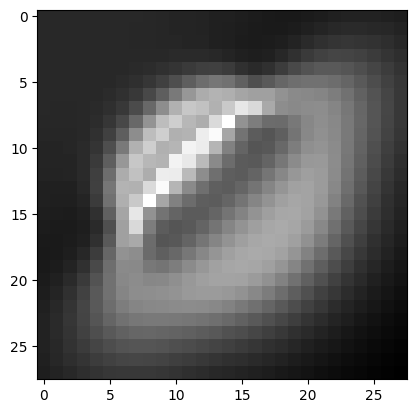

In [46]:
# meshgrid between -1 and 1
size = 28
repeats = 1
x = torch.linspace(-1, -1 + repeats * 2, size * repeats)
y = torch.linspace(-1, -1 + repeats * 2, size * repeats)
x, y = torch.meshgrid(x, y, indexing='xy')

mlp = mlp.cuda()

# evaluate the model on the meshgrid
with torch.no_grad():
    # embedded_coordinates = torch.cat([reflective_sin_emb(x.reshape(-1), 1024), reflective_sin_emb(y.reshape(-1), 1024)], dim=-1).cuda()
    coordinates = torch.stack([x, y], dim=-1).reshape(-1, 2).cuda()
    z = torch.tensor([.7071, .7071], device='cuda')[None].repeat(size * repeats * size * repeats, 1)
    output = mlp(coordinates, z)


    output = output.view(size * repeats, size * repeats)

plt.imshow(output.cpu(), cmap='gray')
plt.savefig("test.png")

In [47]:
bv = ca.random_grade(2)
bv = bv / ca.norm(bv)
# Rotate by 2pi / 8 
num_rotations = 8
R = ca.exponential(bv * torch.pi / num_rotations)

tensor([0.0000, 1.0000], device='cuda:0')
torch.Size([784, 2]) torch.Size([784, 2])
torch.Size([784, 2]) torch.Size([784, 2])


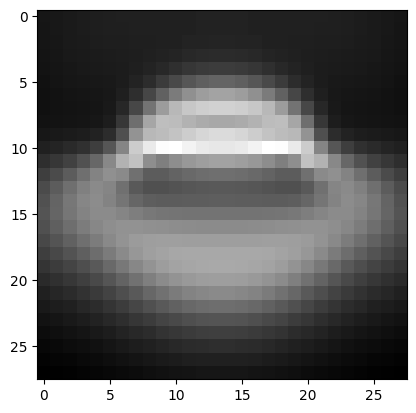

tensor([-0.7071,  0.7071], device='cuda:0')
torch.Size([784, 2]) torch.Size([784, 2])
torch.Size([784, 2]) torch.Size([784, 2])


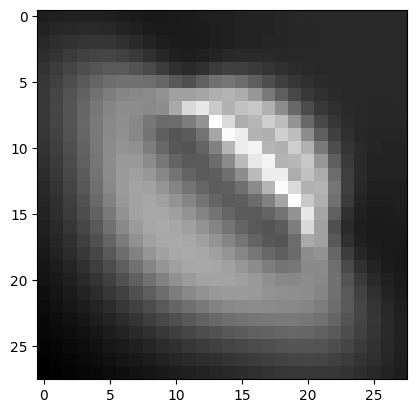

tensor([-9.9999e-01, -2.9802e-08], device='cuda:0')
torch.Size([784, 2]) torch.Size([784, 2])
torch.Size([784, 2]) torch.Size([784, 2])


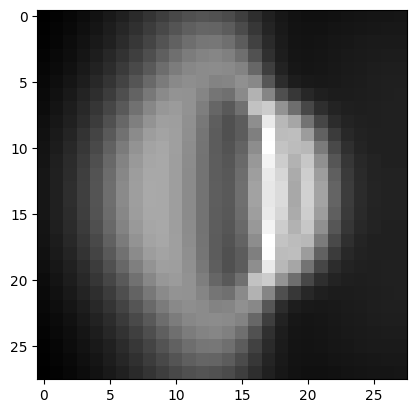

tensor([-0.7071, -0.7071], device='cuda:0')
torch.Size([784, 2]) torch.Size([784, 2])
torch.Size([784, 2]) torch.Size([784, 2])


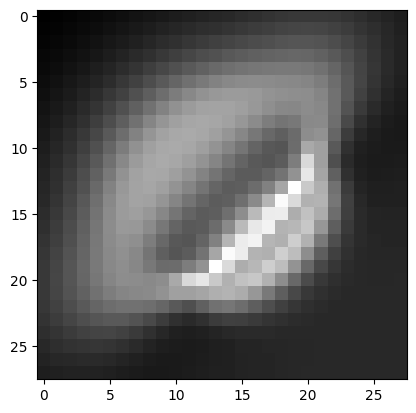

tensor([ 5.9605e-08, -9.9999e-01], device='cuda:0')
torch.Size([784, 2]) torch.Size([784, 2])
torch.Size([784, 2]) torch.Size([784, 2])


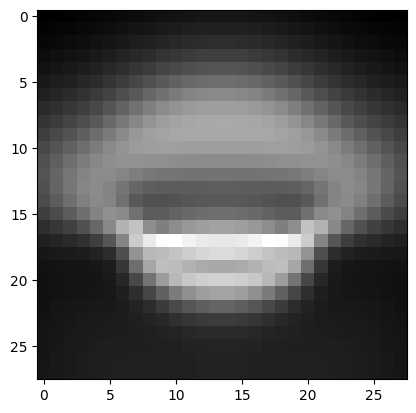

tensor([ 0.7071, -0.7071], device='cuda:0')
torch.Size([784, 2]) torch.Size([784, 2])
torch.Size([784, 2]) torch.Size([784, 2])


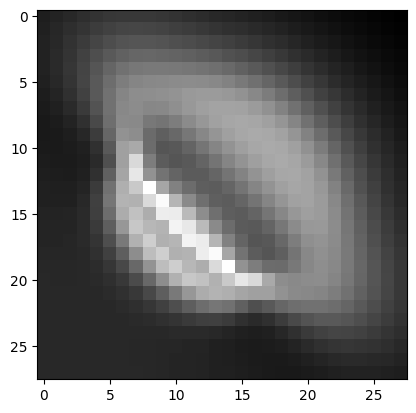

tensor([9.9999e-01, 2.9802e-08], device='cuda:0')
torch.Size([784, 2]) torch.Size([784, 2])
torch.Size([784, 2]) torch.Size([784, 2])


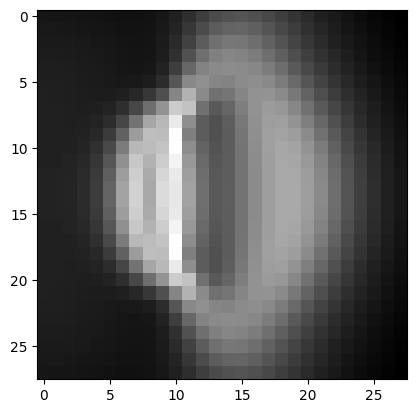

tensor([0.7071, 0.7071], device='cuda:0')
torch.Size([784, 2]) torch.Size([784, 2])
torch.Size([784, 2]) torch.Size([784, 2])


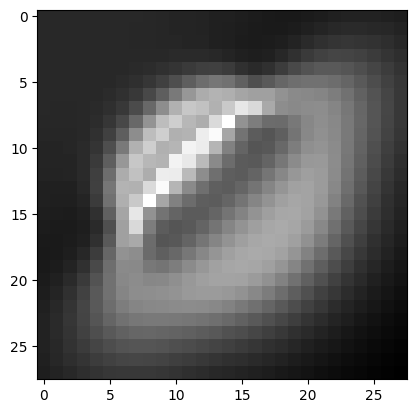

tensor([-2.9802e-08,  9.9999e-01], device='cuda:0')
torch.Size([784, 2]) torch.Size([784, 2])
torch.Size([784, 2]) torch.Size([784, 2])


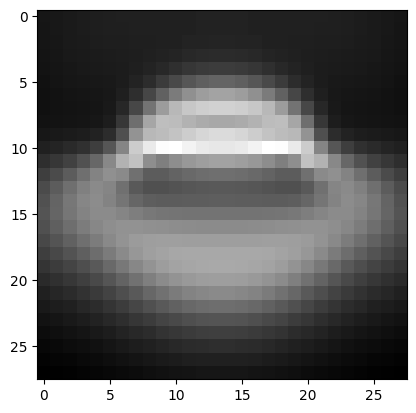

<Figure size 640x480 with 0 Axes>

In [48]:
# evaluate the model on the meshgrid

for i in range(num_rotations + 1):

    with torch.no_grad():

        z = ca.rho(R, ca.embed_grade(z, 1))[..., 1:3]
        print(z[0])
        # embedded_coordinates = torch.cat([reflective_sin_emb(x.reshape(-1), 1024), reflective_sin_emb(y.reshape(-1), 1024)], dim=-1).cuda()
        coordinates = torch.stack([x, y], dim=-1).reshape(-1, 2).cuda()
        output = mlp(coordinates, z)


        output = output.view(size * repeats, size * repeats)

        output = mlp(coordinates, z)


        output = output.view(size * repeats, size * repeats)

    plt.imshow(output.cpu(), cmap='gray')
    plt.show()
    plt.savefig("test.png")